# Surface tension calculations using DFT for Hydrogen-Neon mixtures
Classical density functional theory for interfacial properties of hydrogen, helium, deuterium, neon and their mixtures ([doi:10.1063/5.0137226](https://doi.org/10.1063/5.0137226))

In [1]:
from feos import *
from feos.dft import *
from feos.saftvrqmie import *
import matplotlib.pyplot as plt
import si_units as si
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
import json
from math import ceil

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')

# Set up functional

In [2]:
parameters = SaftVRQMieParameters.from_json(["hydrogen", "neon"], 
                                            "../../parameters/saftvrqmie/hammer2023.json", 
                                            binary_path="../../parameters/saftvrqmie/aasen2020_binary.json")
eos = HelmholtzEnergyFunctional.saftvrqmie(parameters)

# Utility functions

In [3]:
def surftens_mulero2012(fluid, tr):
    """
    Calculate pure fluid surface tension using Mulero et al. 2012 correlation (doi:10.1063/1.4768782)
    Args:
        fluid (str): Component name
        tr (np.ndarray): Reduced temperature
    Returns:
        sigma (np.ndarray): Surface tension (mN/m)
    """
    ff = open("mulero_2012_parameters.json", "r")
    complist = json.load(ff)
    ff.close()
    sigma = np.zeros_like(tr)
    for i in range(len(complist[fluid]["sigma"])):
        sigma[:] += complist[fluid]["sigma"][i] * \
            (1-tr[:])**complist[fluid]["n"][i]
    return sigma * si.NEWTON / si.METER / (si.MILLI * si.NEWTON/  si.METER)

# Set experimental data and constants

In [4]:
# Y. P. Blagoi and V. V. Pashkov
# Surface tension of normal hydrogen solutions in neon
# Sov. phys. JETP 28, 3 (1969)
#
# (Triple point composition is calculated using SAFT-VRQ Mie EoS)
neon_h2_data = {}
#
neon_h2_data["24.59"] = {"P": np.array([1.91, 2.03, 2.52, 2.50]) * 1.01325 * si.BAR,
                         "x_H2": np.array([1.44, 1.57, 2.16, 2.13]) * 0.01,
                         "sigma": np.array([4.09, 3.70, 3.30, 3.13]) * si.MILLI * si.NEWTON / si.METER,
                         "x_triple": np.array([0.03107854, 0.96892146])}
#
neon_h2_data["26.33"] = {"P": np.array([2.06, 2.49, 3.31, 3.99]) * 1.01325 * si.BAR, 
                         "x_H2": np.array([1.22, 1.71, 2.83, 4.11]) * 0.01,
                         "sigma": np.array([4.15, 3.63, 2.98, 2.45]) * si.MILLI * si.NEWTON / si.METER,
                         "x_triple": np.array([0.05122161, 0.94877839])}
#
neon_h2_data["27.15"] = {"P": np.array([2.49, 3.38, 4.09, 4.93]) * 1.01325 * si.BAR, 
                         "x_H2": np.array([1.58, 2.73, 3.84, 5.88]) * 0.01,
                         "sigma": np.array([3.75, 3.00, 2.60, 1.83]) * si.MILLI * si.NEWTON / si.METER,
                         "x_triple": np.array([0.06421055, 0.93578945])}
#
neon_h2_data["29.00"] = {"P": np.array([2.80, 3.36, 3.77, 4.89, 5.90]) * 1.01325 * si.BAR,
                         "x_H2": np.array([1.20, 1.94, 2.54, 4.48, 7.38]) * 0.01,
                         "sigma": np.array([3.51, 3.22, 3.00, 2.37, 1.73]) * si.MILLI * si.NEWTON / si.METER,
                         "x_triple": np.array([0.10680614, 0.89319386])}
#
colors = ["k","g","r","b","grey","orange","cyan"]
tc_neon = 44.49

# Calculate state and surface tension for the experimental points

In [5]:
states_per_T = []
for key in tqdm.tqdm(neon_h2_data):
    T = float(key)
    states_T = []
    for iP, P in enumerate(neon_h2_data[key]["P"]):
        x_h2 = neon_h2_data[key]["x_H2"][iP]
        x = np.array([x_h2, 1.0-x_h2])
        vle = PhaseEquilibrium.bubble_point(eos, T * si.KELVIN, x)
        cp = State.critical_point(eos, x * si.MOL, initial_temperature=40.0*si.KELVIN)
        states_T.append([vle, cp, neon_h2_data[key]["sigma"][iP], x_h2, T])
    states_per_T.append(states_T)

100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


In [6]:
sft_per_T = []
sft = []
for state_T in tqdm.tqdm(states_per_T):
    sft_T = []
    for vle, cp, s_exp, x_h2, T in state_T:
        try:
            sft_T.append({ 
                "dft": PlanarInterface.from_tanh(vle, 1024, 200 * si.ANGSTROM, cp.temperature).solve().surface_tension / (si.MILLI  * si.NEWTON / si.METER),
                "exp": s_exp / (si.MILLI  * si.NEWTON / si.METER),
                "x_h2": x_h2,
                "T": T
            })
            sft.append(sft_T[-1])
        except Exception as e:
            print(e)
            print(vle)
    sft_per_T.append(sft_T)

100%|██████████| 4/4 [00:21<00:00,  5.42s/it]


# Calculate mean absolute deviation (MAD)

In [7]:
df = pd.DataFrame(sft)
mad = 100*np.sum(np.abs((df.dft-df.exp)/df.exp))/df.exp.shape[0]
print(f"MAD={mad:.1f} %")

MAD=7.5 %


# Plot surface tension error

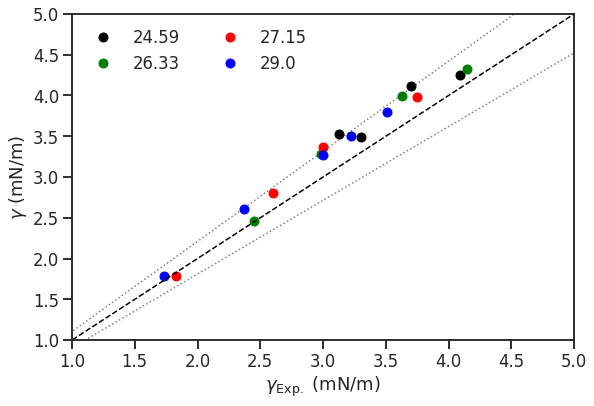

In [8]:
plt.figure(figsize=(9, 6))
err_fan = 0.1
groups = df.groupby('T')
for i, res in enumerate(groups):
    name=res[0]
    group=res[1]
    plt.plot(group.exp, group.dft, "o", color=colors[i], label=str(name))
plt.plot([0, 5], [0, 5], color="black", linestyle="dashed", alpha=1.0, lw=1.5)
plt.plot([0, 5*(1+err_fan/2)], [0, 5*(1-err_fan/2)], color="black", linestyle="dotted", alpha=0.5, lw=1.5)
plt.plot([0, 5*(1-err_fan/2)], [0, 5*(1+err_fan/2)], color="black", linestyle="dotted", alpha=0.5, lw=1.5)
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.ylabel(r'$\gamma$ (mN/m)')
plt.xlabel(r'$\gamma_{\rm{Exp.}}$ (mN/m)')
leg = plt.legend(loc='best', ncol=2, frameon=False)

# Calculate isotherms from pure fluid to triple point

In [9]:
dft_sft_per_T = []
for key in tqdm.tqdm(neon_h2_data):
    T = float(key)
    x_T = neon_h2_data[key]["x_triple"] # Triple point
    dft_sft_T = []
    # Add some safety margin for the numerical differences between Thermopack and FEOS
    x_h2 = np.linspace(1.0e-8, x_T[0]-1.0e-3, ceil(x_T[0]/0.005))
    for x in x_h2:
        z = np.array([x, 1.0-x])
        vle = PhaseEquilibrium.bubble_point(eos, T * si.KELVIN, z)
        cp = State.critical_point(eos, z * si.MOL, initial_temperature=40.0*si.KELVIN)
        try:
            dft_sft_T.append({ 
                "dft": PlanarInterface.from_tanh(vle, 1024, 200 * si.ANGSTROM, cp.temperature).solve().surface_tension / (si.MILLI  * si.NEWTON / si.METER),
                "x_h2": x
            })
        except Exception as e:
            print(x)
            print(T)
            print(cp)
            print(e)
            print(vle)
    dft_sft_per_T.append(dft_sft_T)

100%|██████████| 4/4 [01:16<00:00, 19.06s/it]


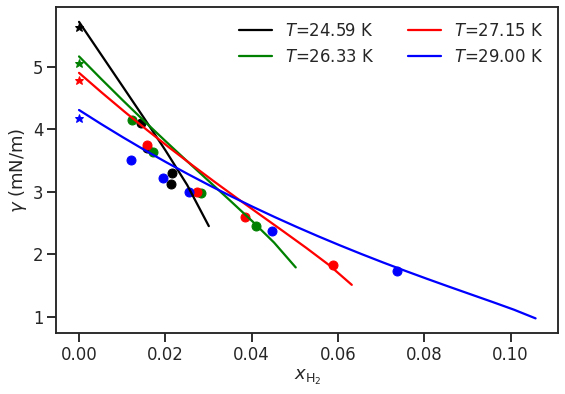

In [10]:
plt.figure(figsize=(9, 6))
for i, sft in enumerate(sft_per_T):
    df_T = pd.DataFrame(sft)
    plt.plot(df_T.x_h2, df_T.exp, "o", color=colors[i])

labels = []
for key in neon_h2_data:
    labels.append("$T$="+key+" K")

for i, sft in enumerate(dft_sft_per_T):
    df_T = pd.DataFrame(sft)
    plt.plot(df_T.x_h2, df_T.dft, color=colors[i], label=labels[i])

for i, key in enumerate(neon_h2_data):
    tr = np.array([float(key)/tc_neon])
    s_mulero = surftens_mulero2012("neon", tr)
    plt.plot([0.0], s_mulero, "*", color=colors[i])

plt.ylabel(r'$\gamma$ (mN/m)')
plt.xlabel(r'$x_{\rm{H_2}}$')
leg = plt.legend(loc='best', ncol=2, frameon=False)